In [1]:
%load_ext lab_black
%load_ext memory_profiler

from copy import deepcopy
from os import listdir
from os.path import isfile, join
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.io
from PIL import Image
from PIL import ImageDraw
import json
from random import random
import numpy as np
import cv2
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.resnet50 import preprocess_input
import os
import errno, os, stat, shutil
from tqdm.notebook import tqdm
from enum import Enum

import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19

from keras.layers import *
from keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from datetime import datetime
from focal_loss import BinaryFocalLoss

# tf.debugging.set_log_device_placement(True)
plt.rcParams["figure.figsize"] = [40, 20]
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices("GPU")))

Num GPUs Available:  1


In [2]:
from datautils import *
from ArrayLoader import *
from CWDataset import *
from augmentation import *

In [3]:
original_path = Path("data/CW/original")
generated_path = Path("data/CW/generated")

In [4]:
real_shape = (544, 1280, 3)
save_shape = (544 // 4, 1280 // 4, 3)
augmented_samples = 6

In [5]:
dataset = CWDataset(generated_path)

Train 1156
Test  137
Vali  137


In [6]:
def labels_to_bitmap(labels, res_shape, source_shape):
    image = np.array(np.zeros(res_shape, dtype=float))
    for label in labels:
        tmp = np.asarray(
            list(
                (
                    int(label[0] * res_shape[1] / source_shape[1]),
                    int(label[1] * res_shape[0] / source_shape[0]),
                    int(label[2] * res_shape[1] / source_shape[1]),
                    int(label[3] * res_shape[0] / source_shape[0]),
                )
            )
        )

        image[tmp[1] : tmp[3], tmp[0] : tmp[2]] = 1

    return image

In [7]:
def test_dataset_bitmap():
    img, labels = dataset.get_train(5)

    bitmap = labels_to_bitmap(labels[0], (100, 244), img[0].shape[:2])

    plot_images((img[0],), 1, (), (labels[0],))
    plt.imshow(np.abs(bitmap), cmap="gray")
    plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 96.89it/s]


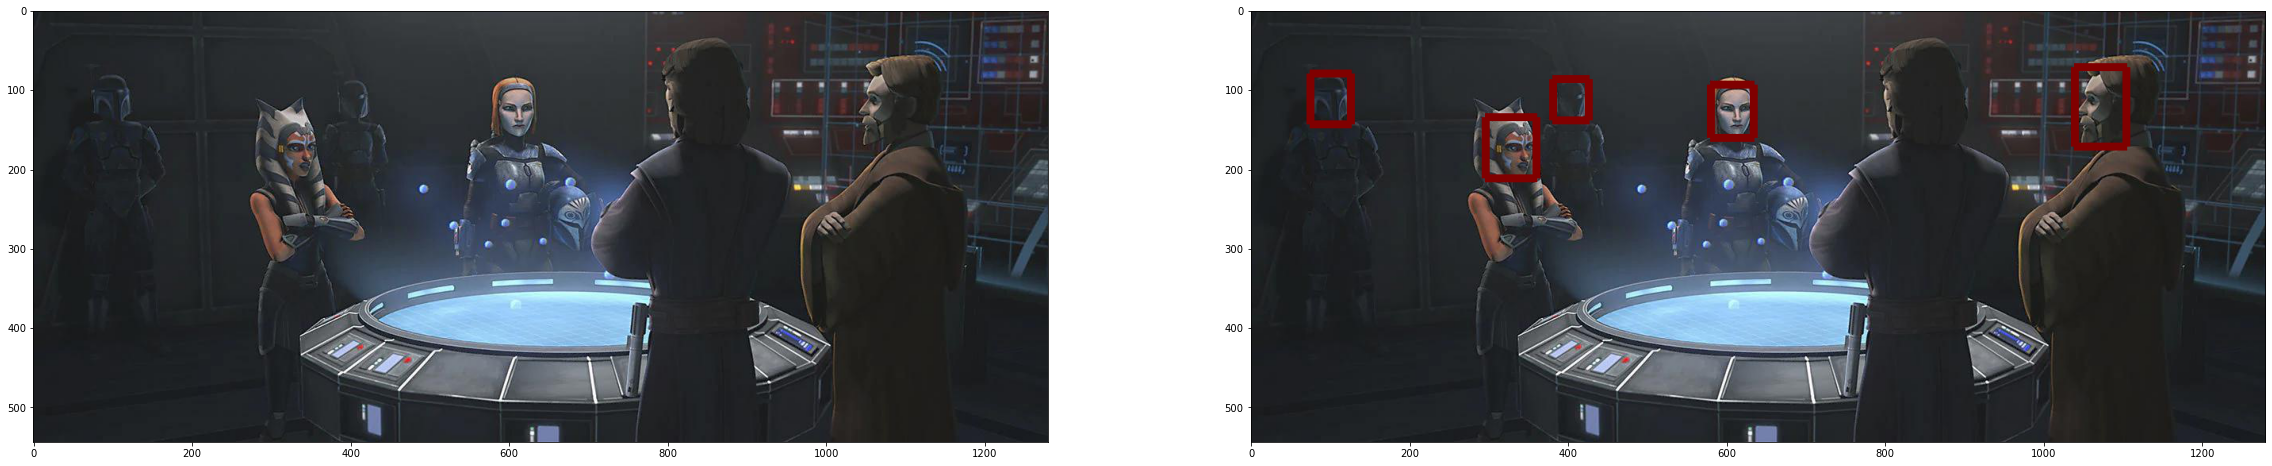

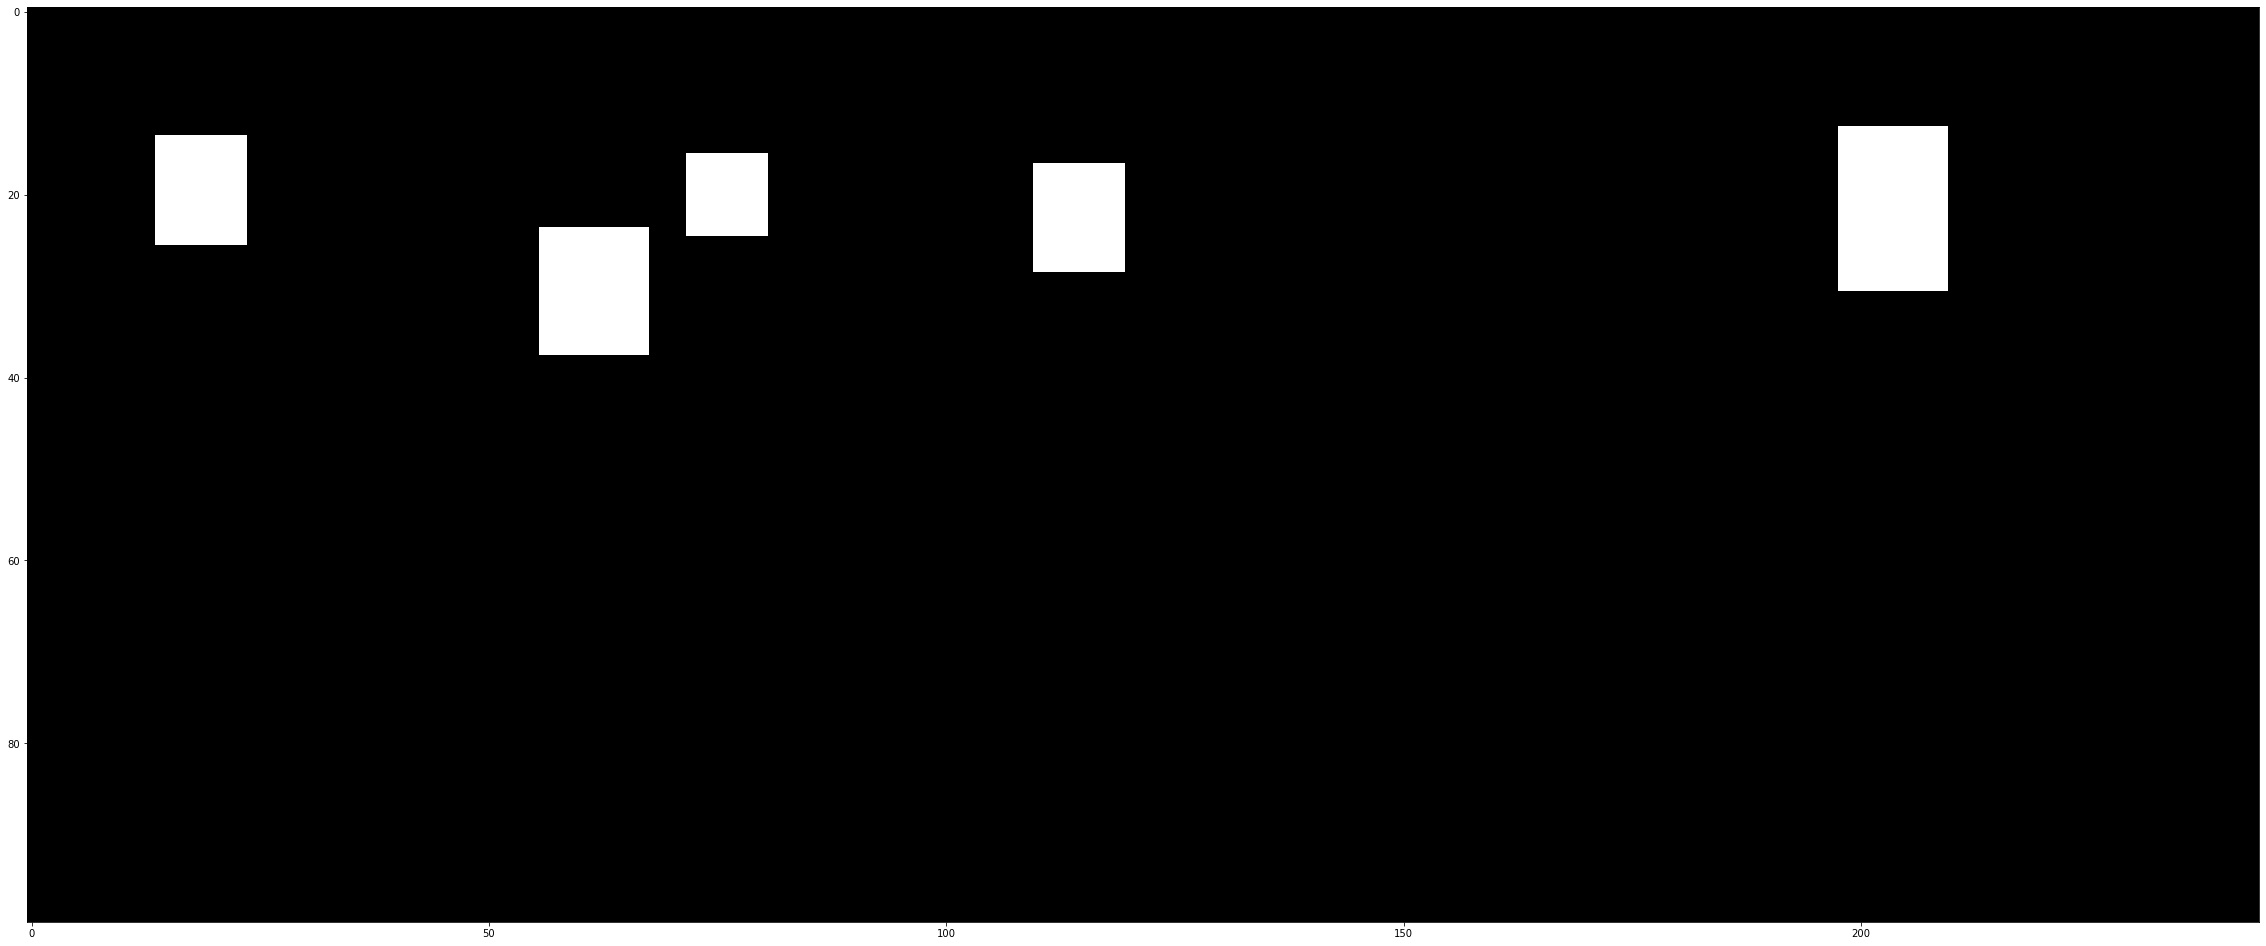

In [8]:
test_dataset_bitmap()

In [9]:
# def prepare_dataset(images, labels, input_shape):
#     X = []
#     Y = []
#     for i in range(len(images)):
#         arr = cv2.resize(
#             deepcopy(images[i]),
#             dsize=(input_shape[1], input_shape[0]),
#             interpolation=cv2.INTER_AREA,
#         )
#         arr = arr.astype(float) / 255.0
#         X.append(arr)
#         Y.append(labels_to_bitmap(labels[i], input_shape, images[i].shape))
#     Y = np.asarray(Y)
#     return np.asarray(X), Y  # Y.reshape(Y.shape[0], -1)

In [10]:
def apply_heatmap(heatmap, level=0.7):
    #     print(heatmap.max())
    #     heatmap[heatmap < level] = 0
    #     heatmap[heatmap >= level] = 1

    #     kernel = np.ones((5, 5), np.uint8)
    #     heatmap = cv2.erode(heatmap, kernel, iterations=1)

    return heatmap


def show_on_data(img, labels, coun, model, shape=save_shape[:2], threshold=0.7):
    for i in range(coun):
        plot_images((img[i],), 1, (), (labels[i],))
        x_tmp, y_tmp = prepare_dataset(
            img[i : i + 1],
            (labels[i],),
            shape,
        )
        predict = model.predict(x_tmp)
        real_heatmap = labels_to_bitmap(labels[i], shape, img[i].shape)
        plt1 = plt.subplot(1, 2, 1)
        plt1.imshow(np.abs(real_heatmap), cmap="gray")
        plt2 = plt.subplot(1, 2, 2)
        plt2.imshow(np.abs(apply_heatmap(predict[0], threshold)), cmap="gray")
        plt.show()

In [11]:
def buildvgg16_model():
    vgg16_model = VGG16(weights="imagenet", include_top=True)
    for layers in (vgg16_model.layers)[:15]:
        layers.trainable = False

    headModel = vgg16_model.layers[-2].output
    headModel = Flatten(name="flatten_outer")(headModel)
    headModel = Dense(512, activation="relu")(headModel)
    headModel = Dense(224 * 224, activation="sigmoid")(headModel)
    headModel = Reshape((224, 224))(headModel)

    model = Model(inputs=vgg16_model.input, outputs=headModel)
    model.compile(
        loss=BinaryFocalLoss(gamma=3),  # "mean_absolute_error",
        optimizer=Adam(lr=0.0001),
        metrics=["accuracy"],
    )
    return model

In [12]:
def train_vgg_model():
    vgg16_model = buildvgg16_model()
    # vgg16_model = tf.keras.models.load_model("model/vgg/09-12-2020 13-55-30.h5")

    X, Y = prepare_dataset(*dataset.get_train(5000, shape=(224, 224)), (224, 224))
    X_val, Y_val = prepare_dataset(
        *dataset.get_validation(5000, shape=(224, 224)), (224, 224)
    )

    my_callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_loss"),
        tf.keras.callbacks.TensorBoard(log_dir="./logs"),
    ]

    # vgg16_model.load_weights("model/vgg/09-12-2020 13-55-30.h5")
    with tf.device("/GPU:0"):
        vgg16_model.fit(
            X,
            Y,
            epochs=50,
            use_multiprocessing=True,
            validation_data=(X_val, Y_val),
            callbacks=my_callbacks,
        )

    dt_string = datetime.now().strftime("model/vgg/%d-%m-%Y %H-%M-%S.h5")
    print("saving as " + dt_string)
    vgg16_model.save(dt_string)
    del X
    del Y
    del X_val
    del Y_val
    return vgg16_model

In [13]:
# vgg16_model = train_vgg_model()
vgg16_model = tf.keras.models.load_model("model/vgg/09-12-2020 13-55-30.h5")
print(vgg16_model.summary())


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 111.39it/s]


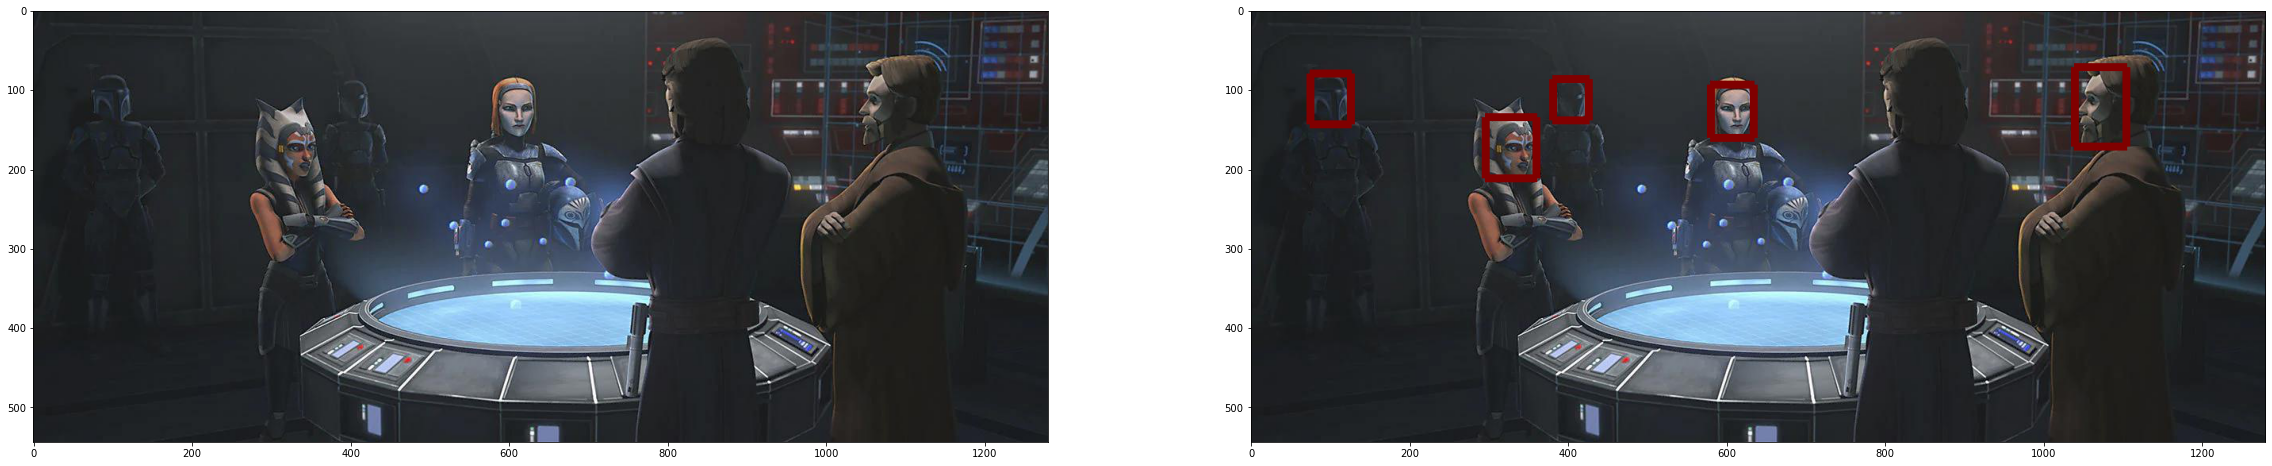

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 248.88it/s]


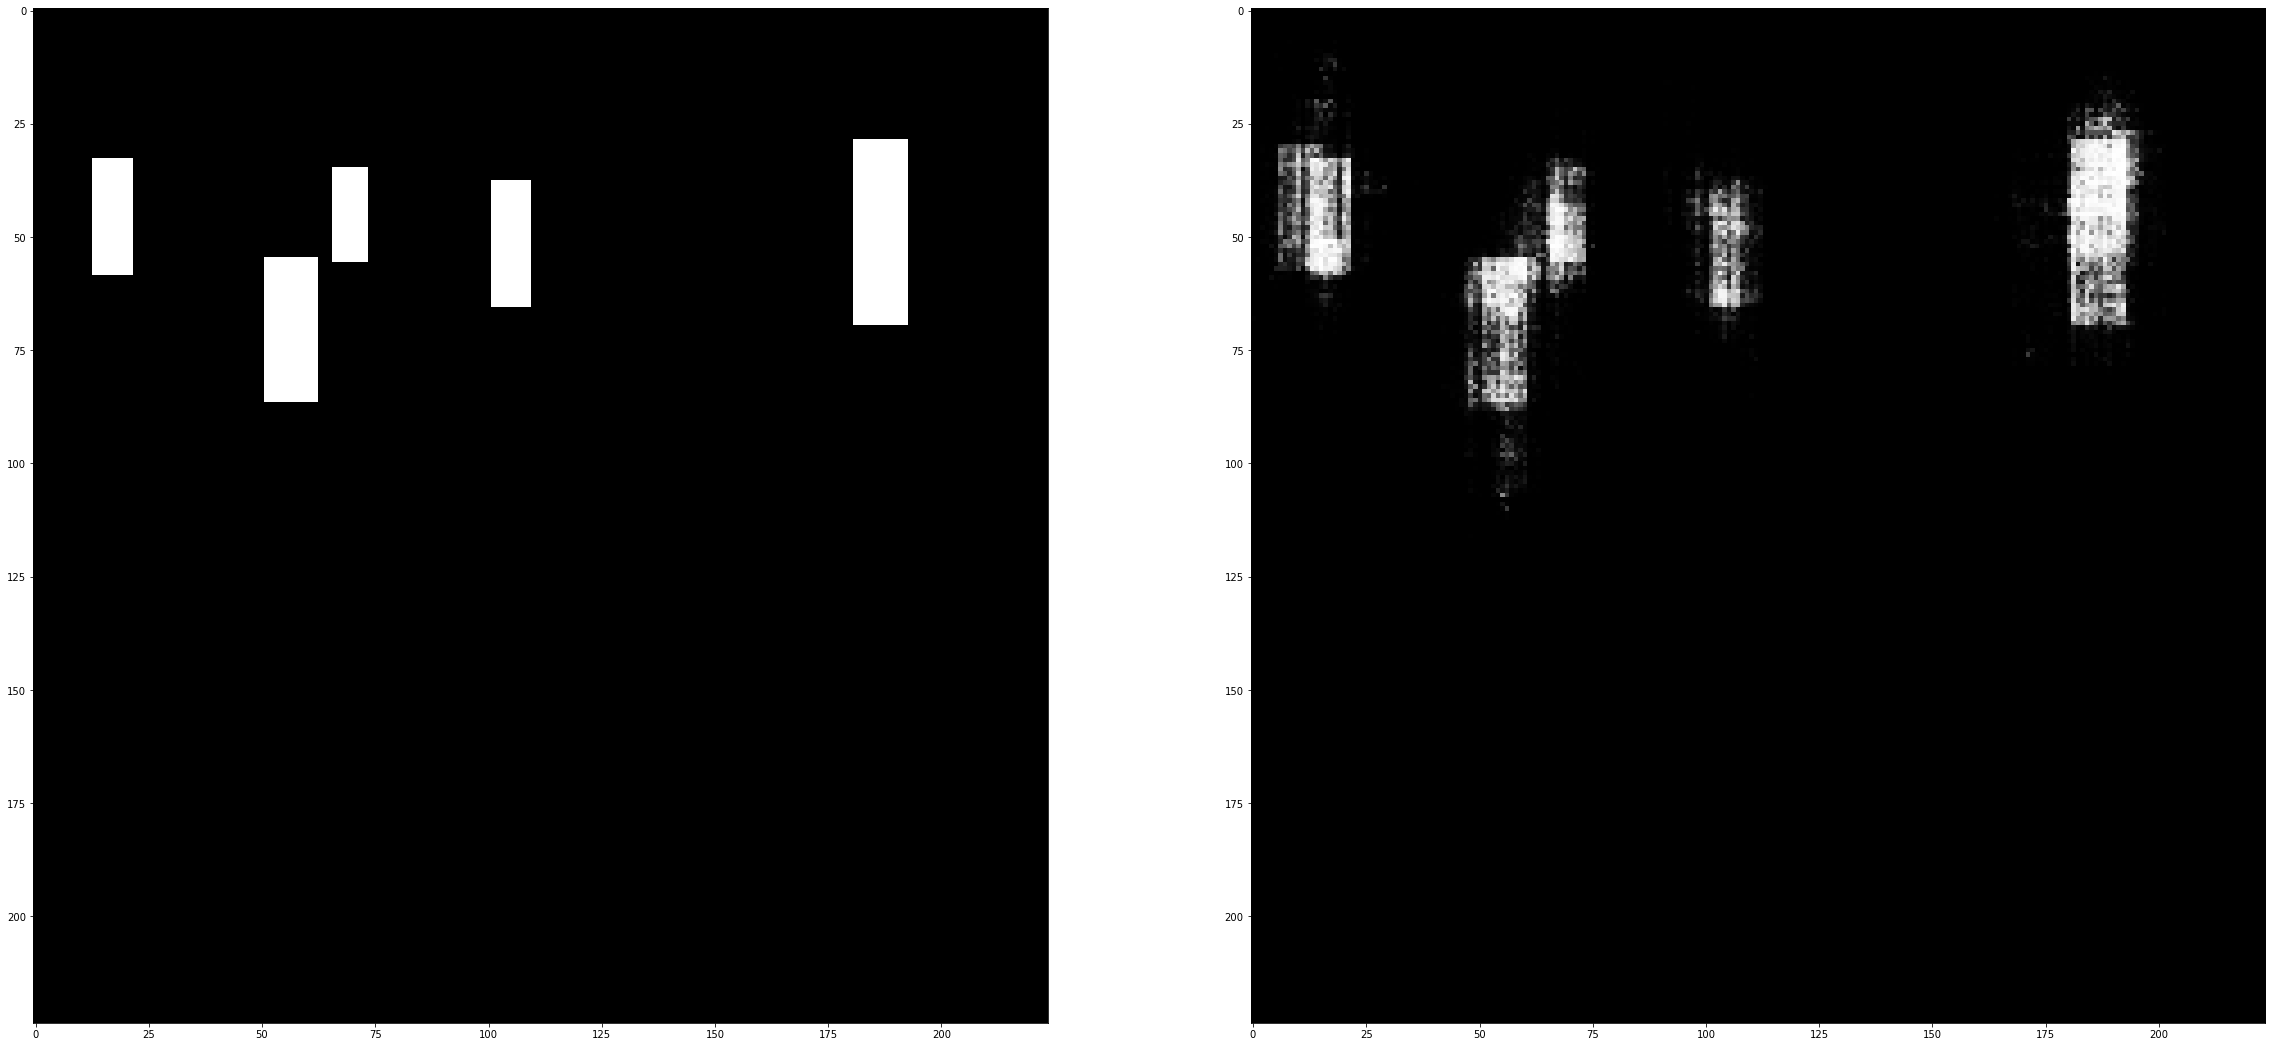

In [14]:
show_on_data(*dataset.get_train(50), 1, vgg16_model, (224, 224), 0.1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 111.94it/s]


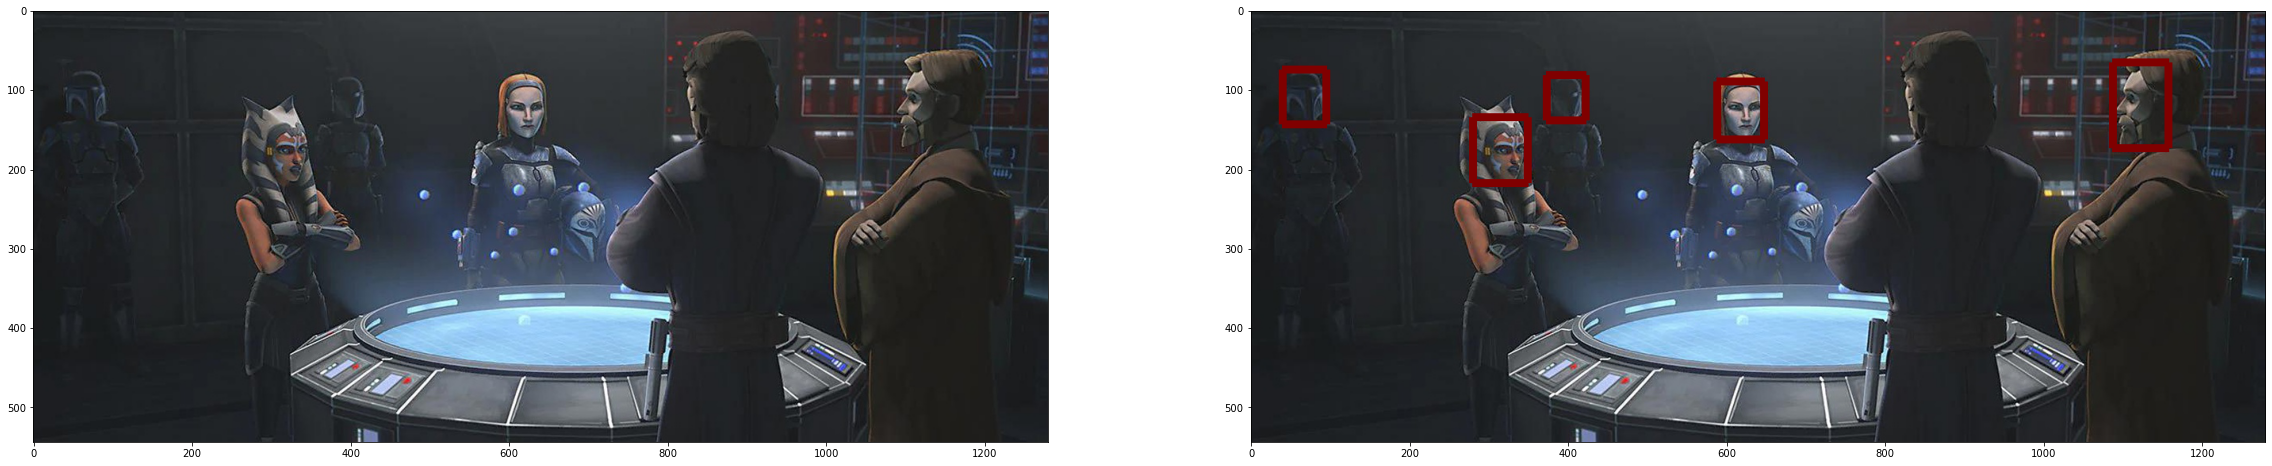

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.69it/s]


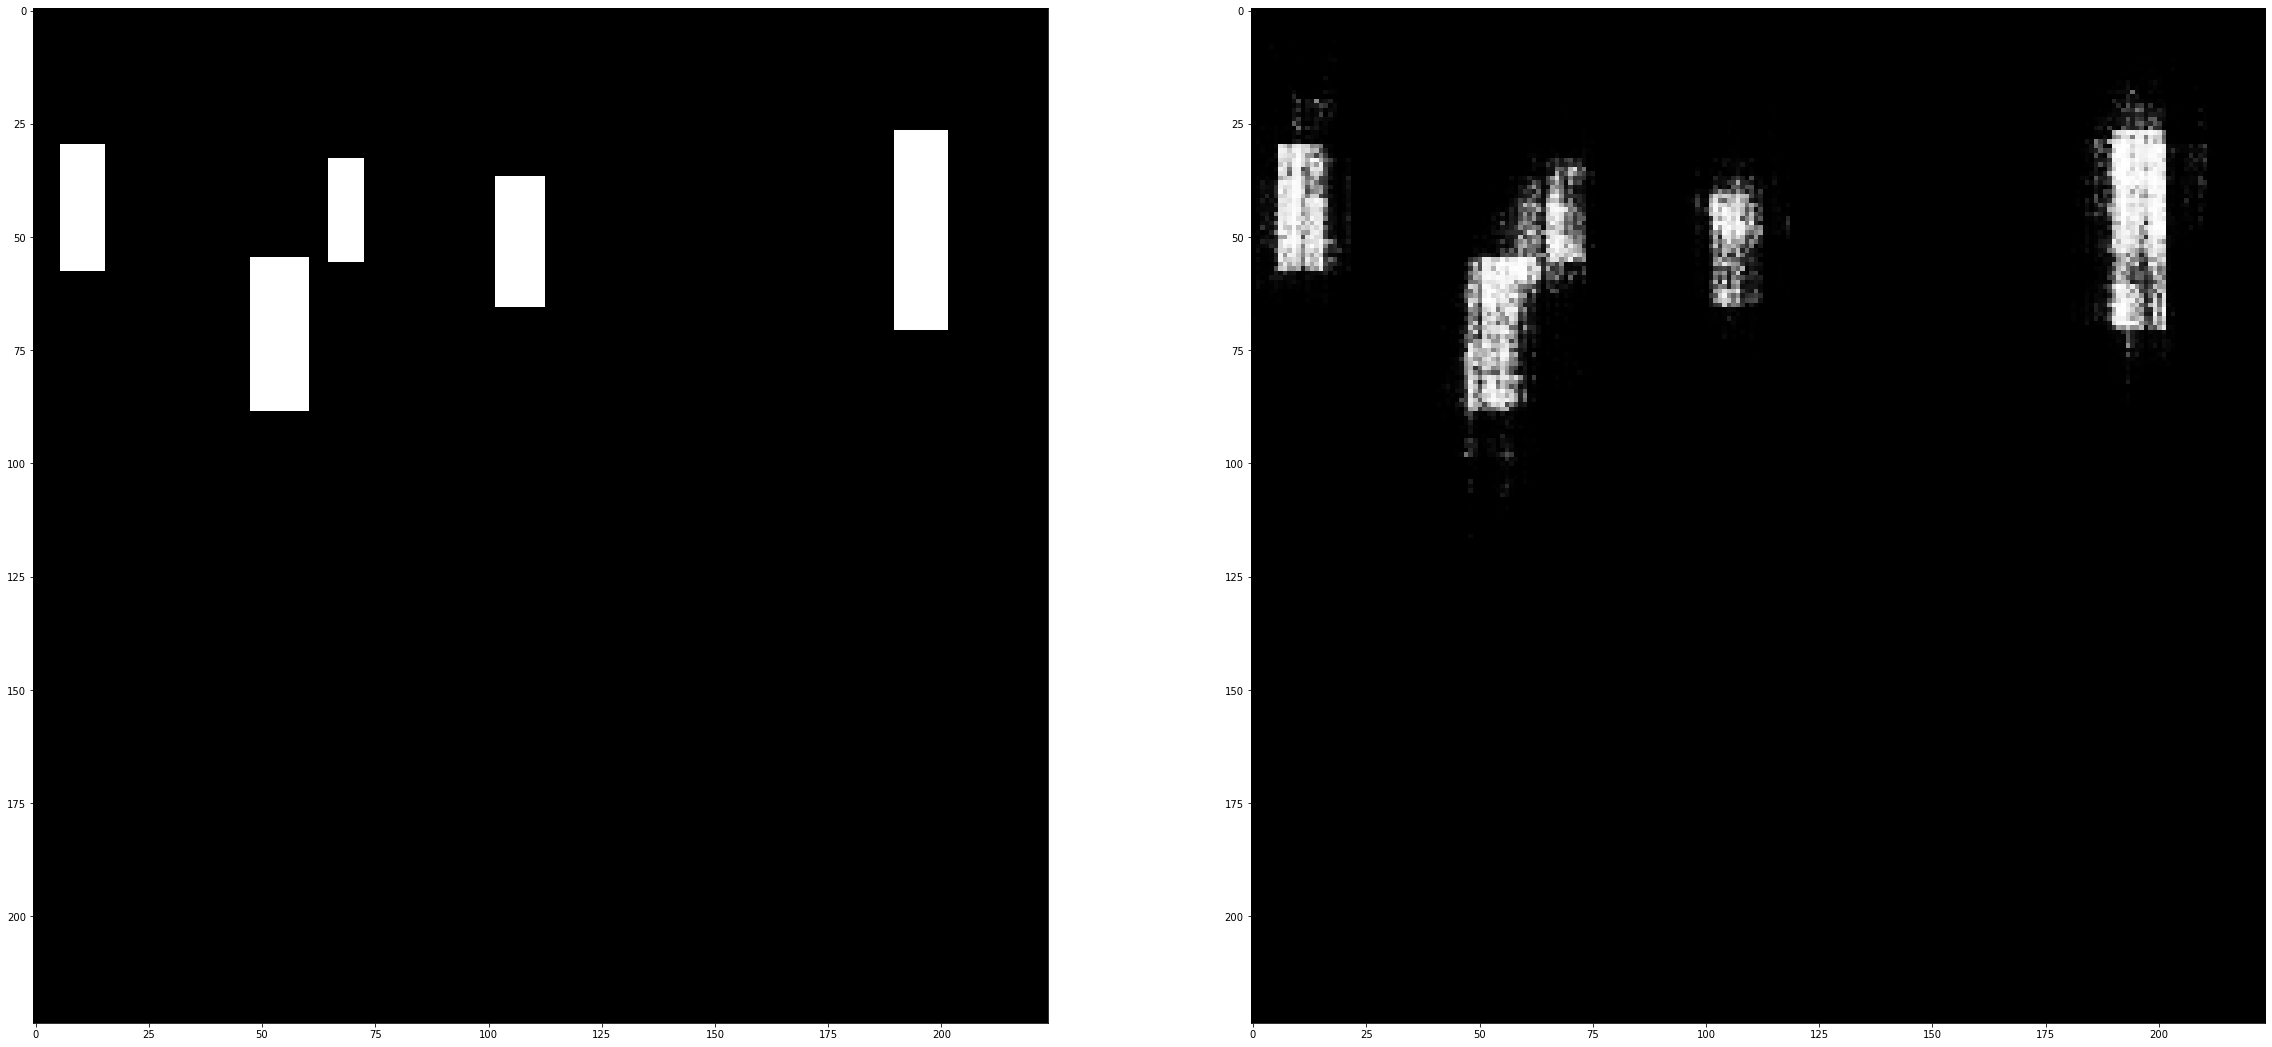

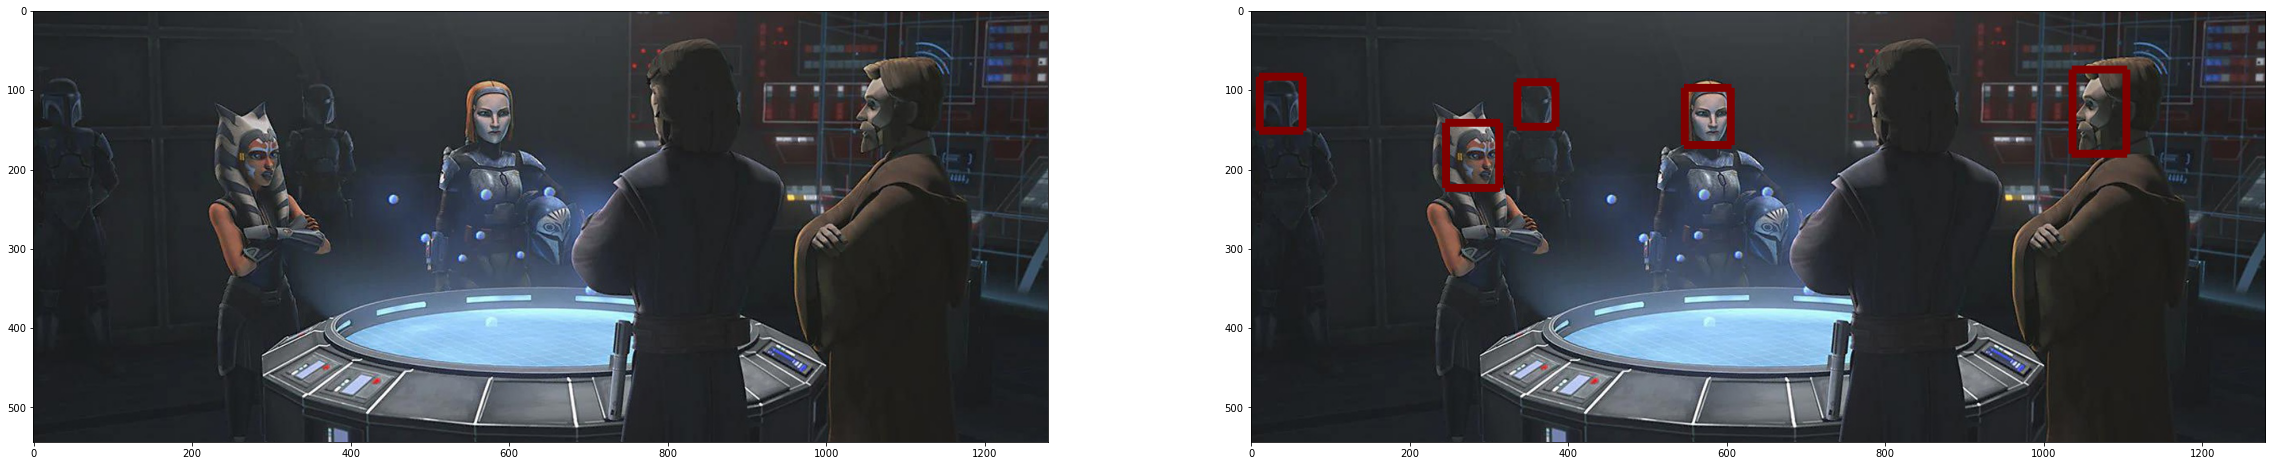

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.75it/s]


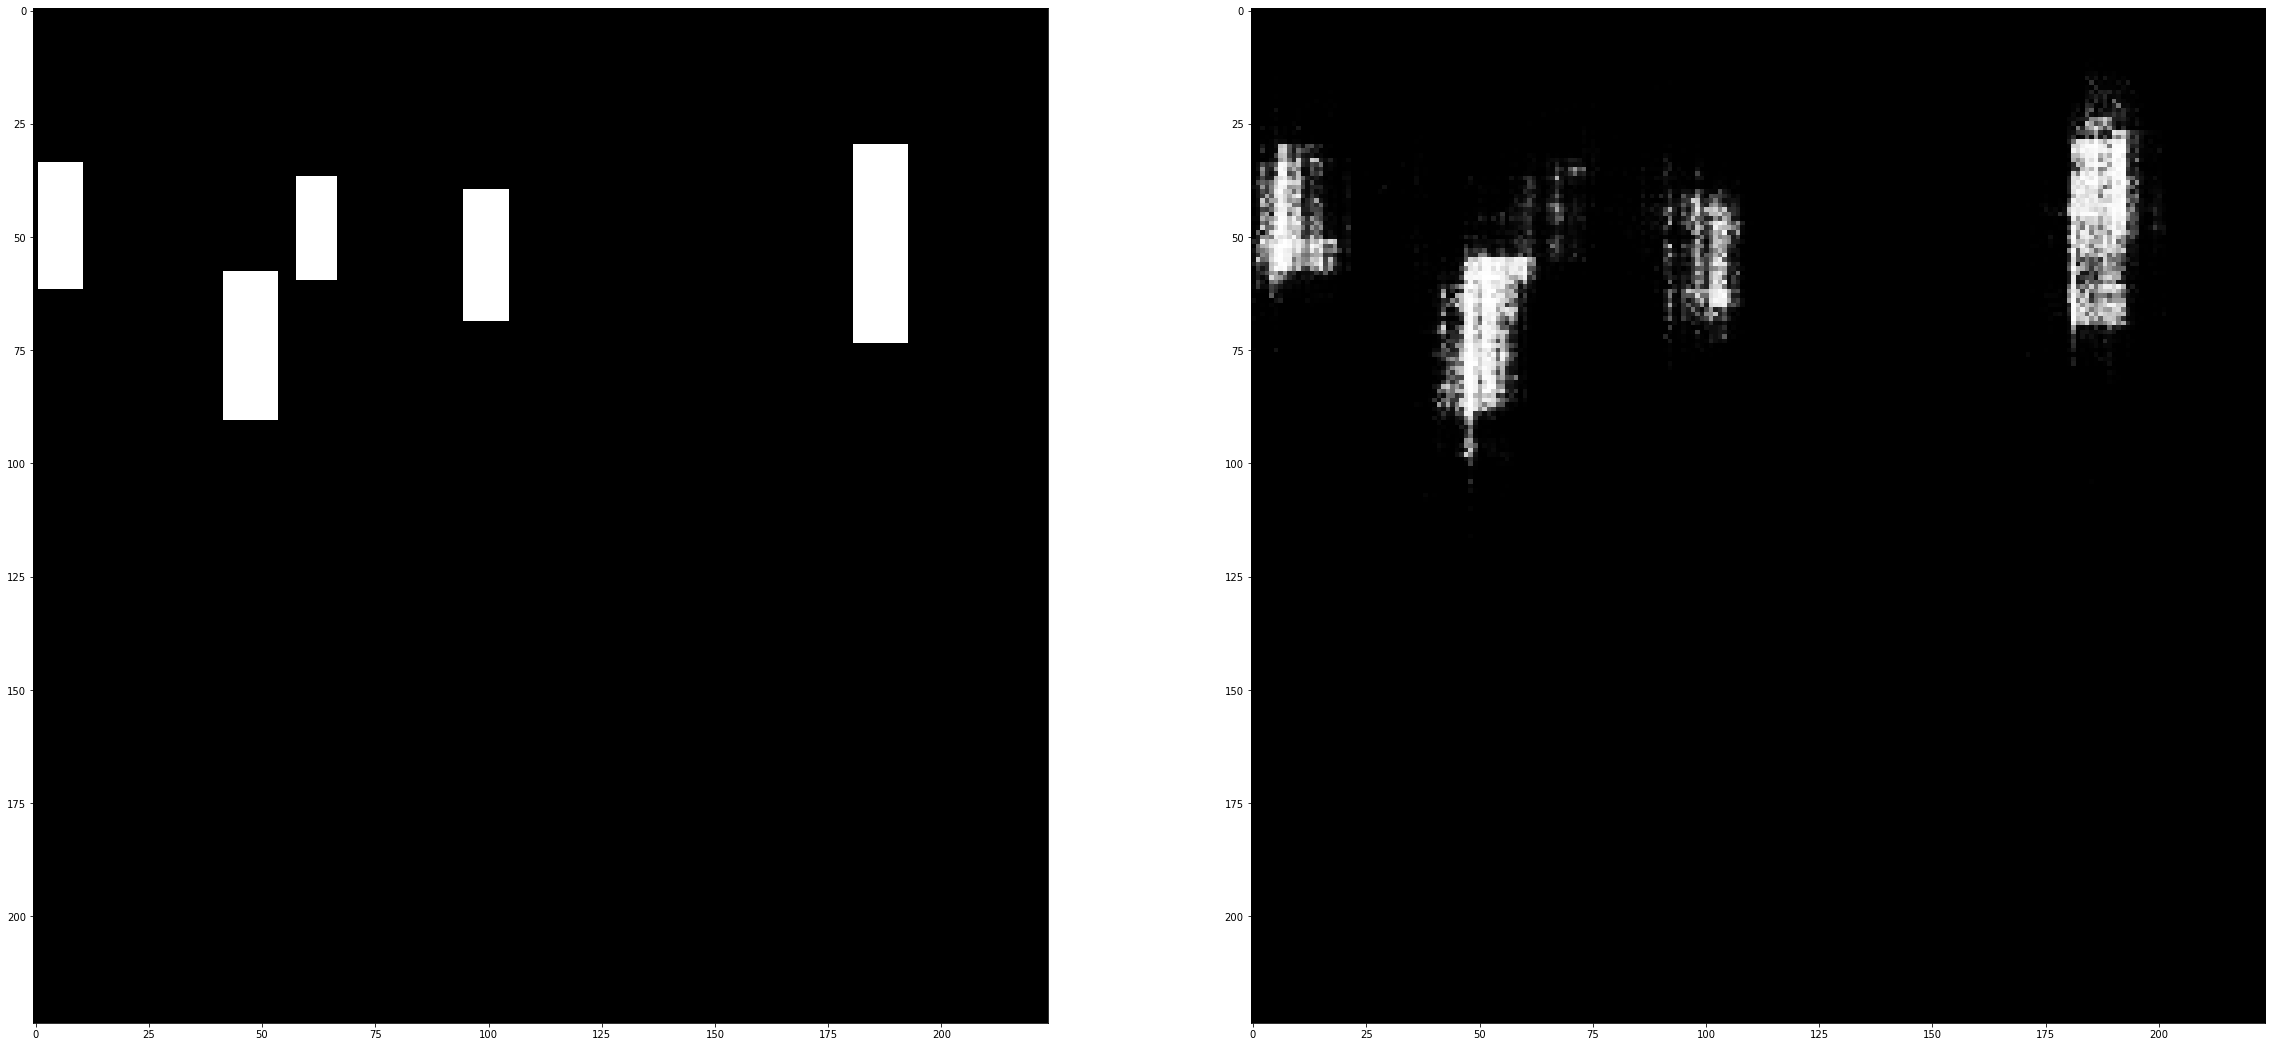

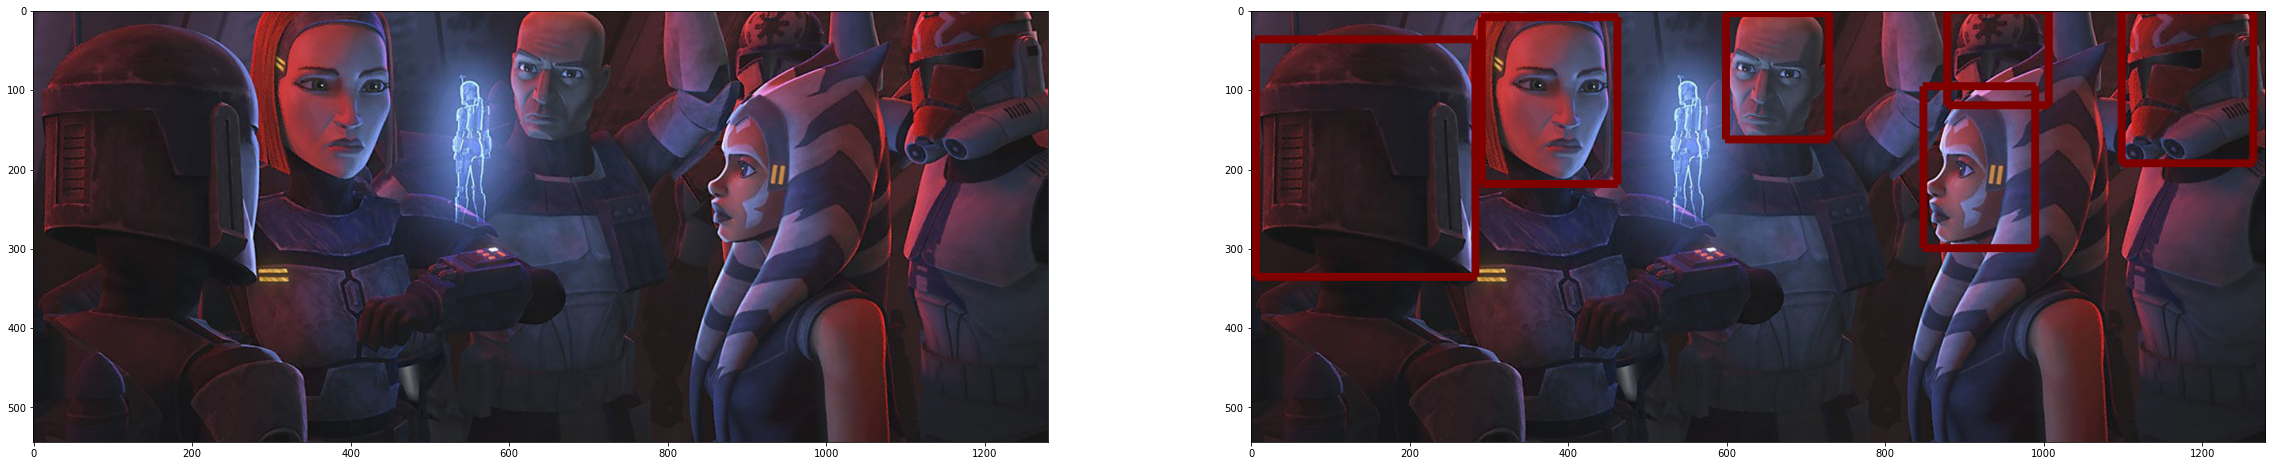

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


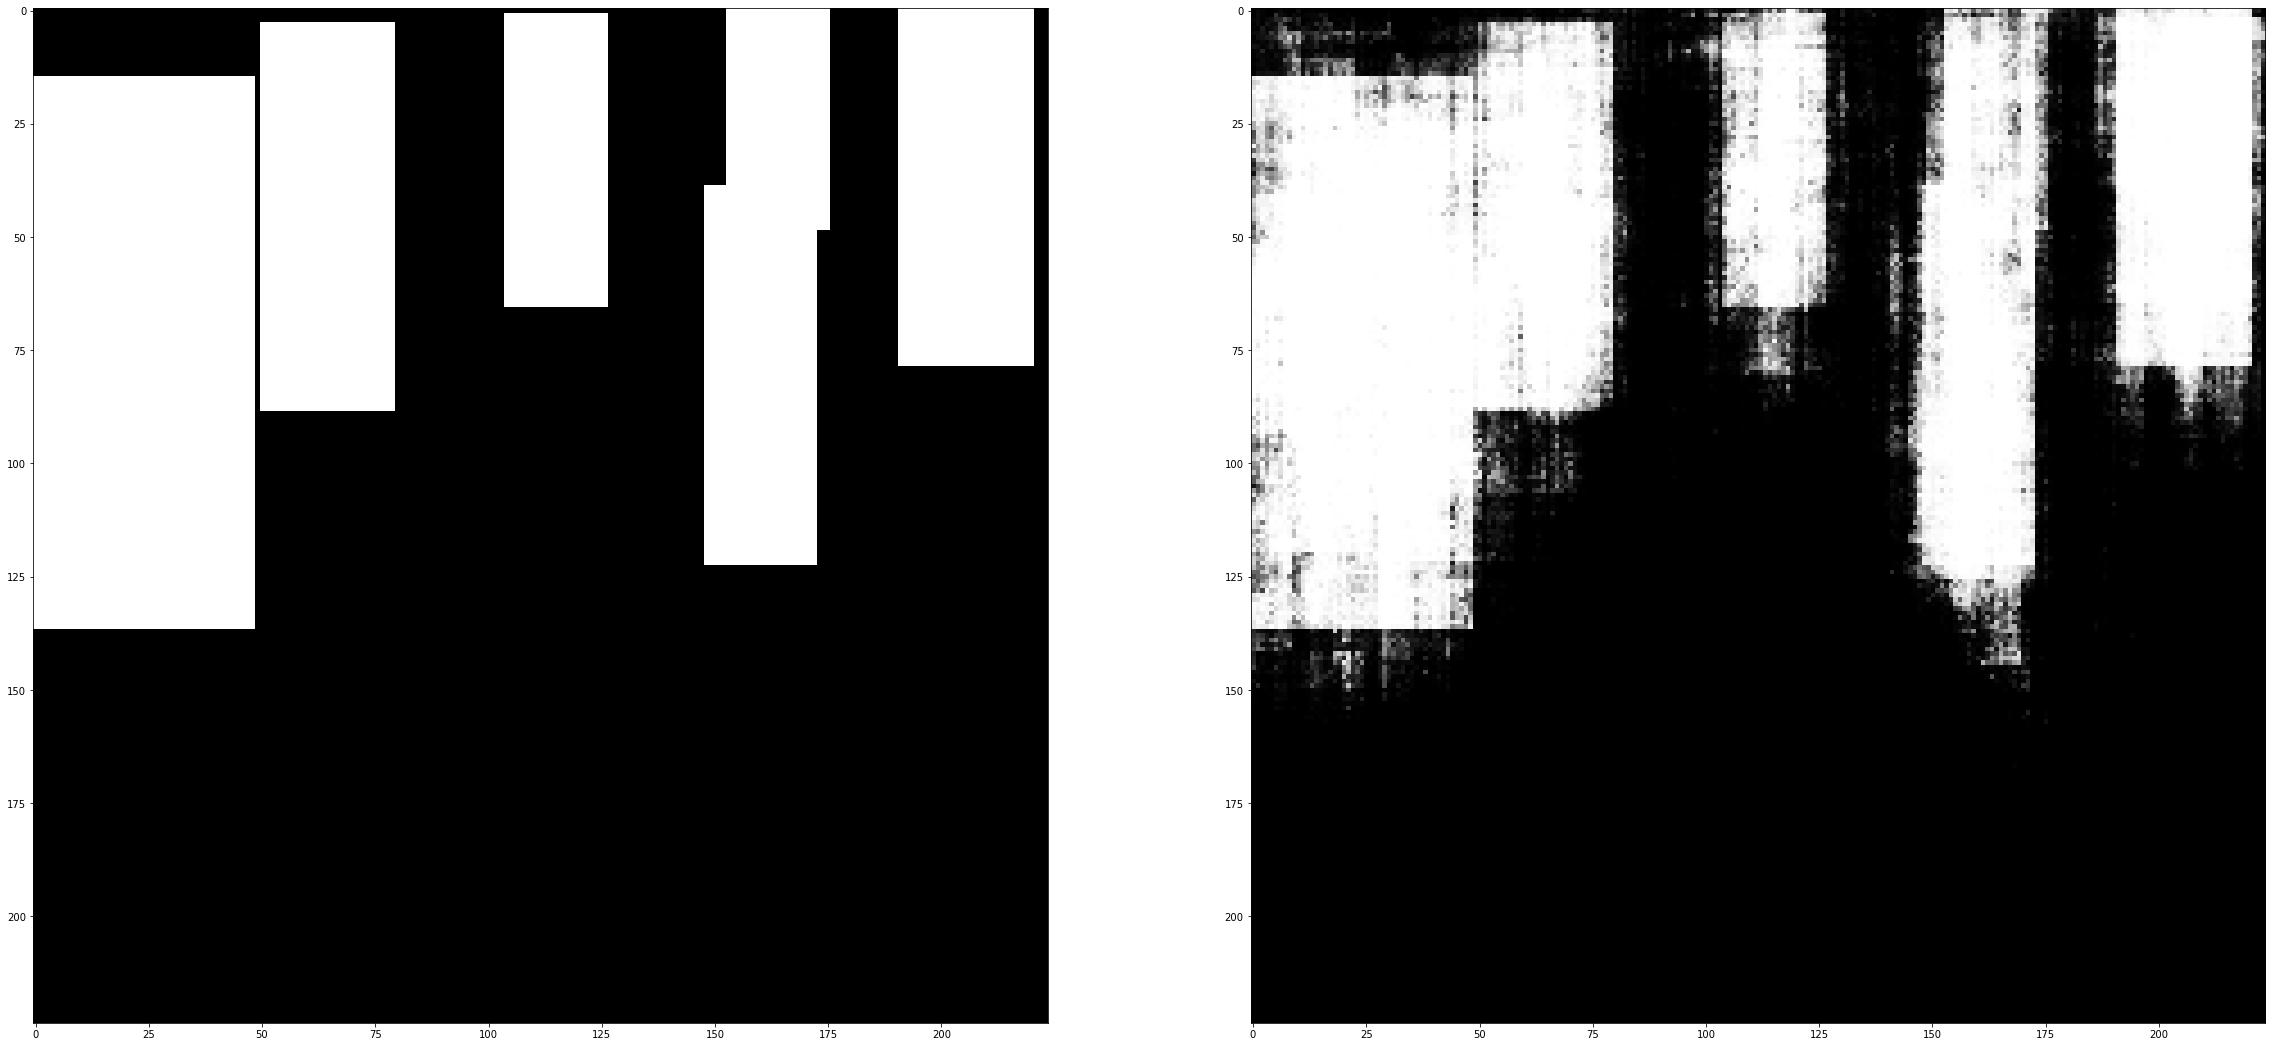

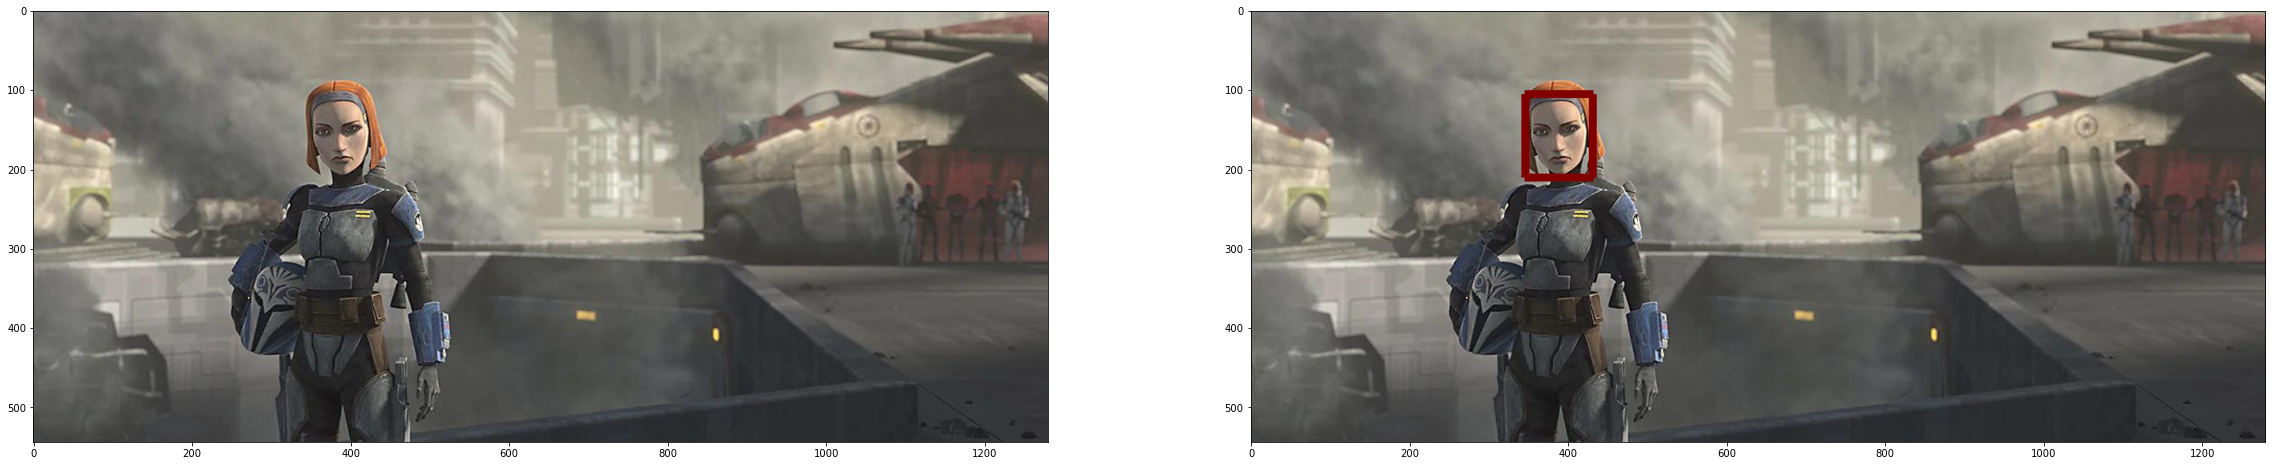

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


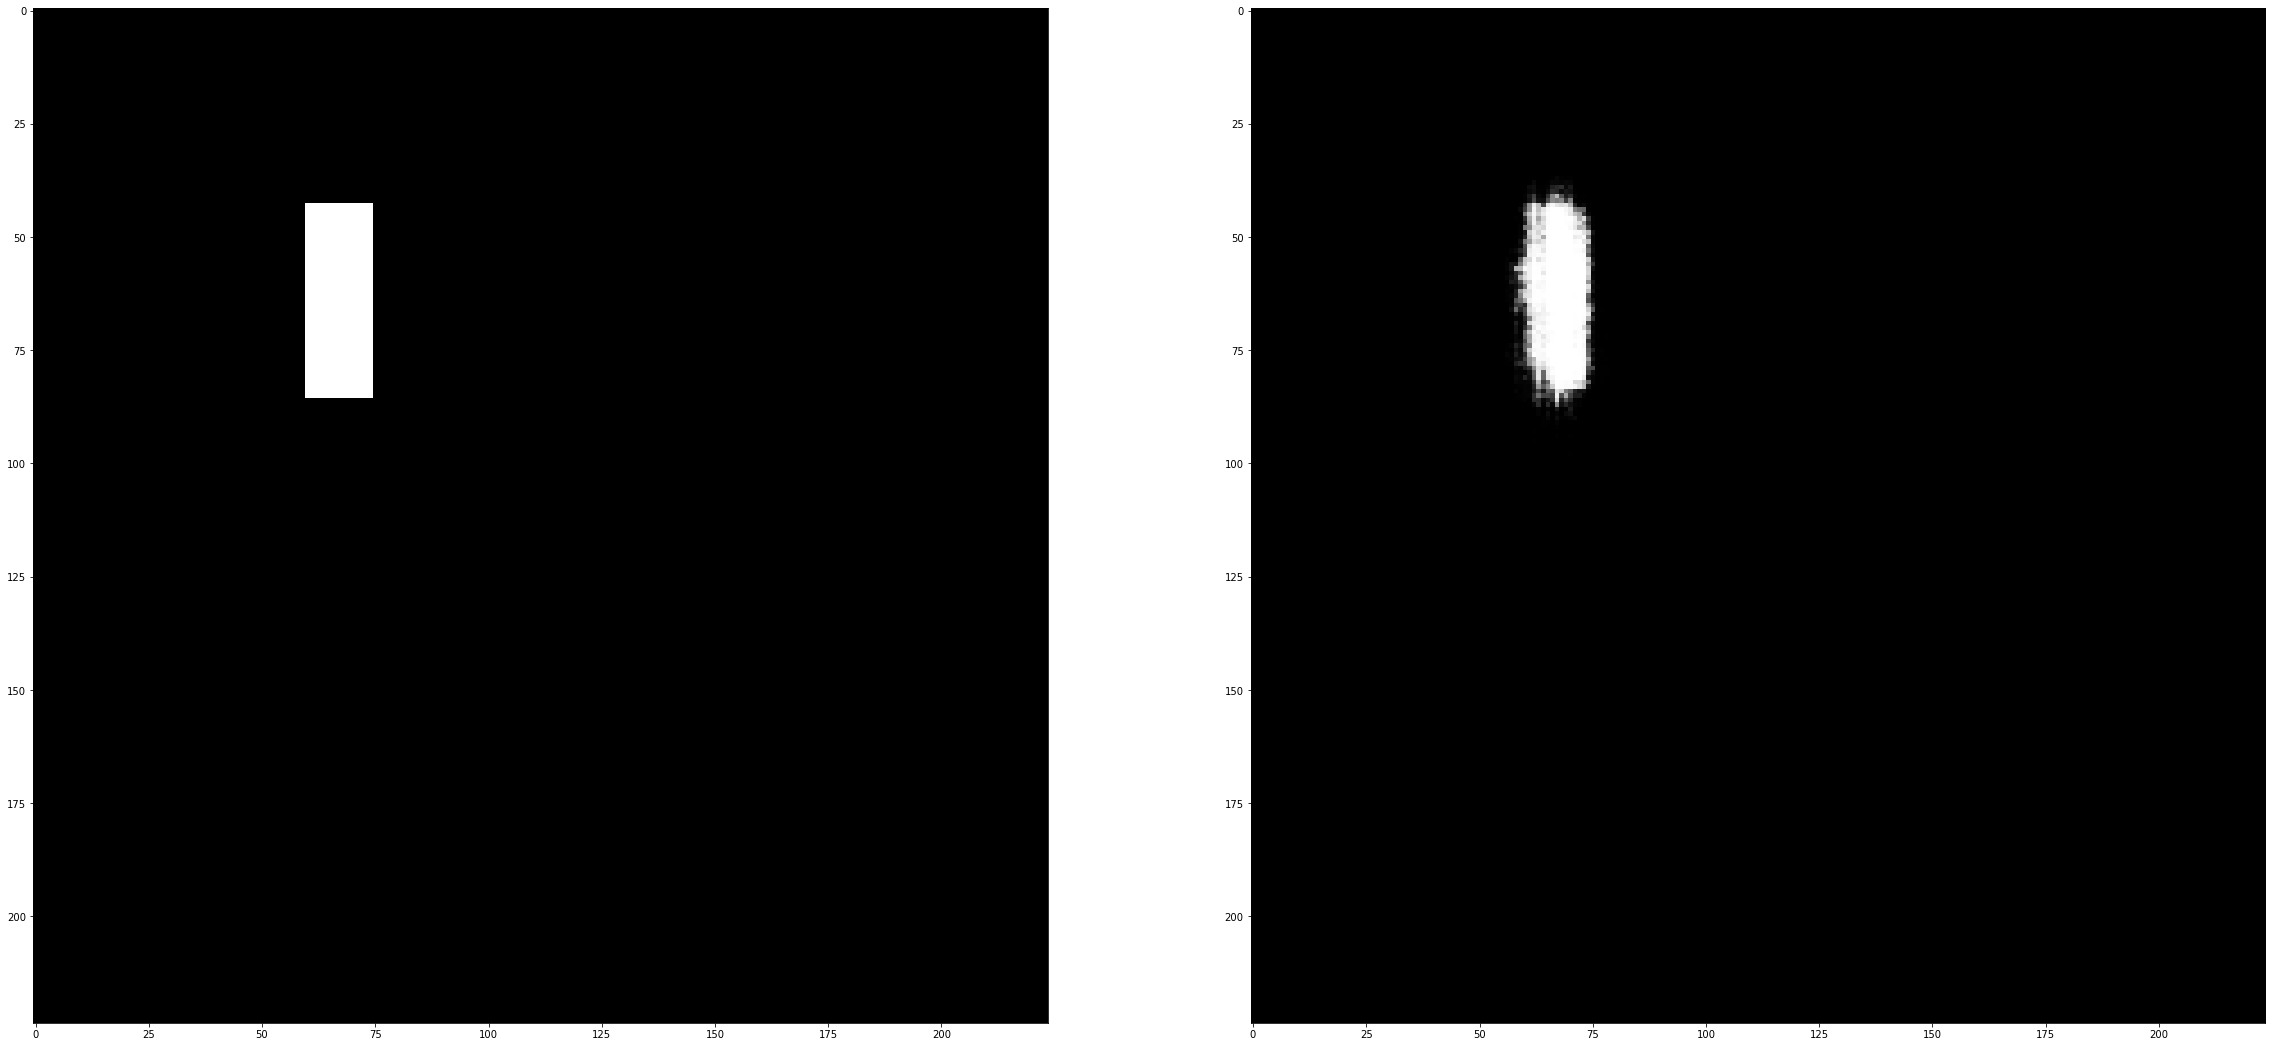

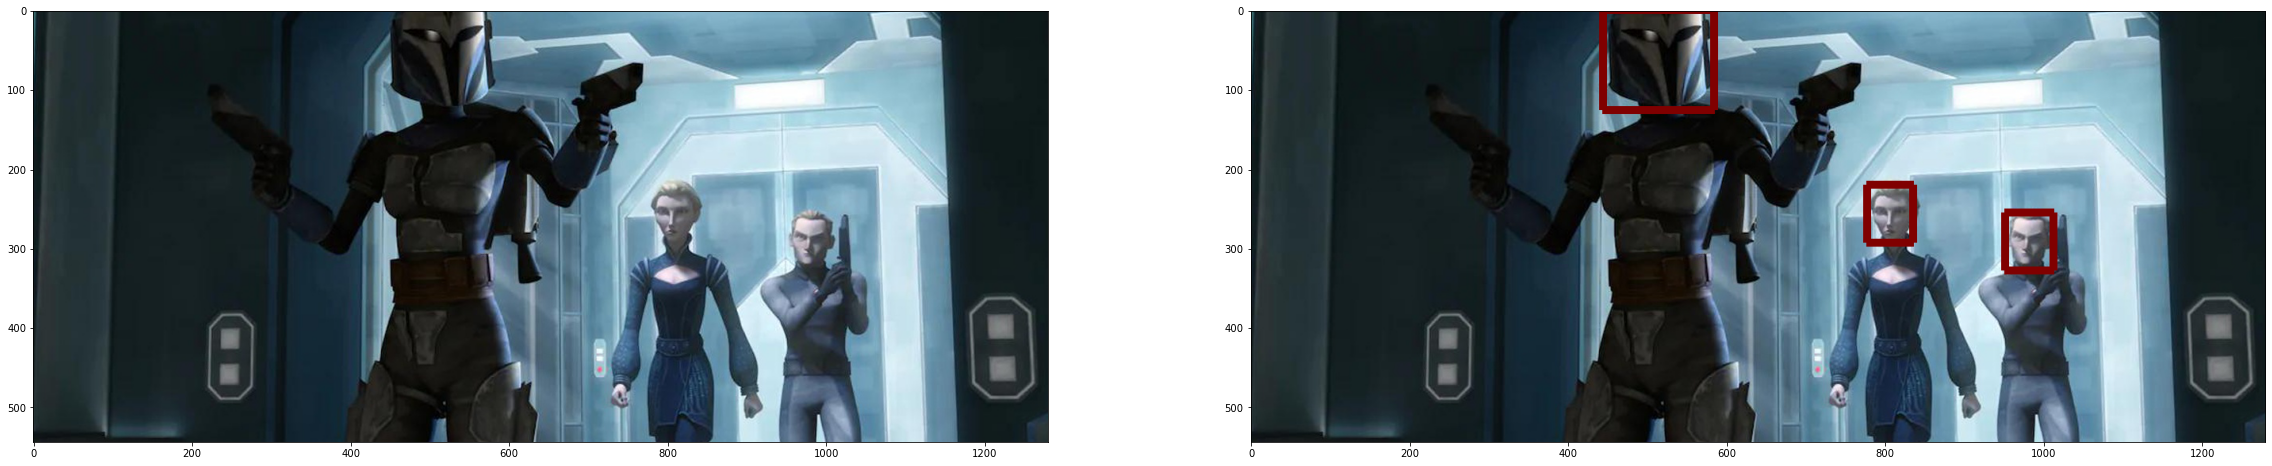

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 200.55it/s]


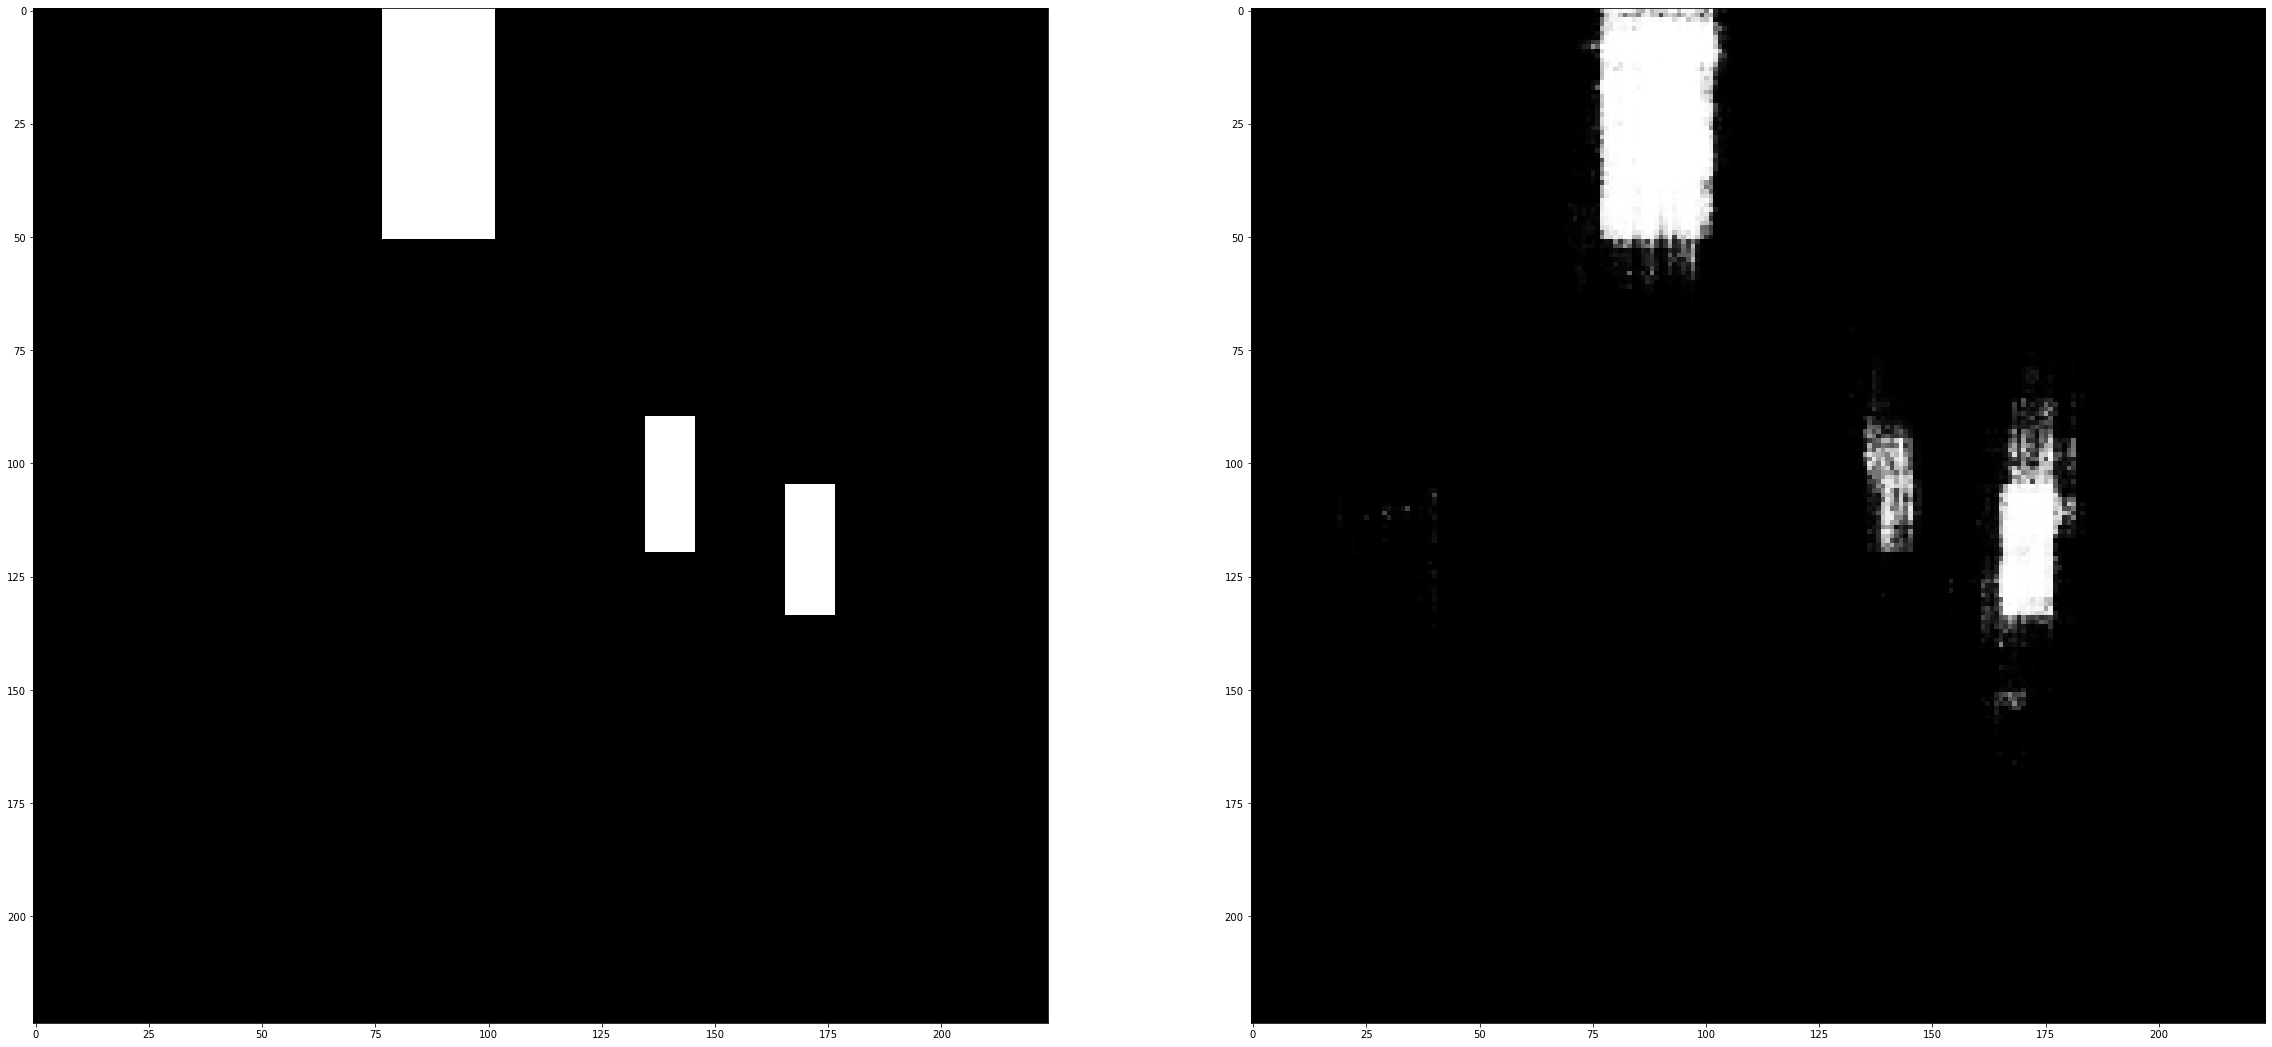

In [15]:
show_on_data(*dataset.get_test(50), 5, vgg16_model, (224, 224))

In [16]:
def show_labeled(arrays, labels, model, threshold=0.8):
    X, Y = prepare_dataset(arrays, labels, (224, 224))
    pred = vgg16_model.predict(X)
    pred_labels = [
        probs_to_labels_with_coefs(pred[i], threshold, 1280 / 224, 544 / 224)
        for i in range(len(pred))
    ]

    plot_images(arrays, 5000, labels, pred_labels)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.88it/s]


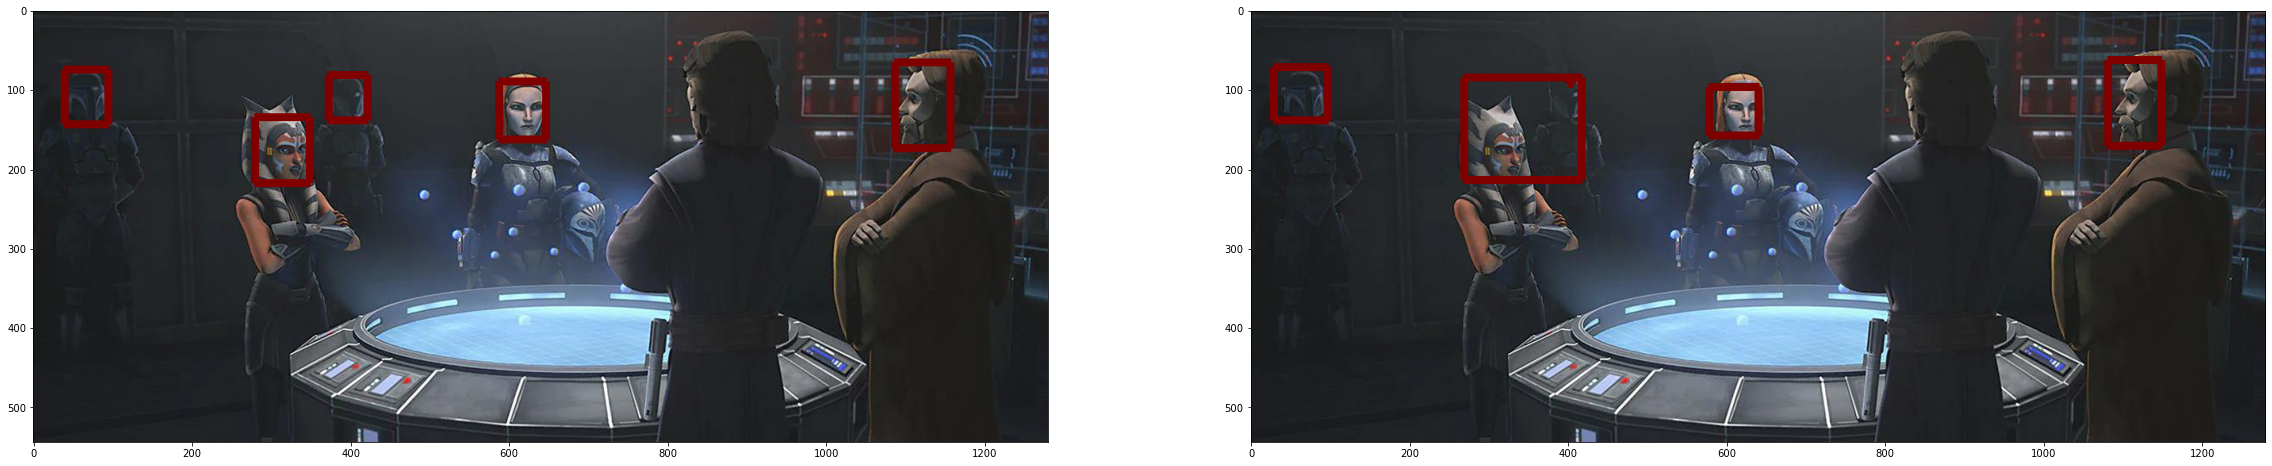

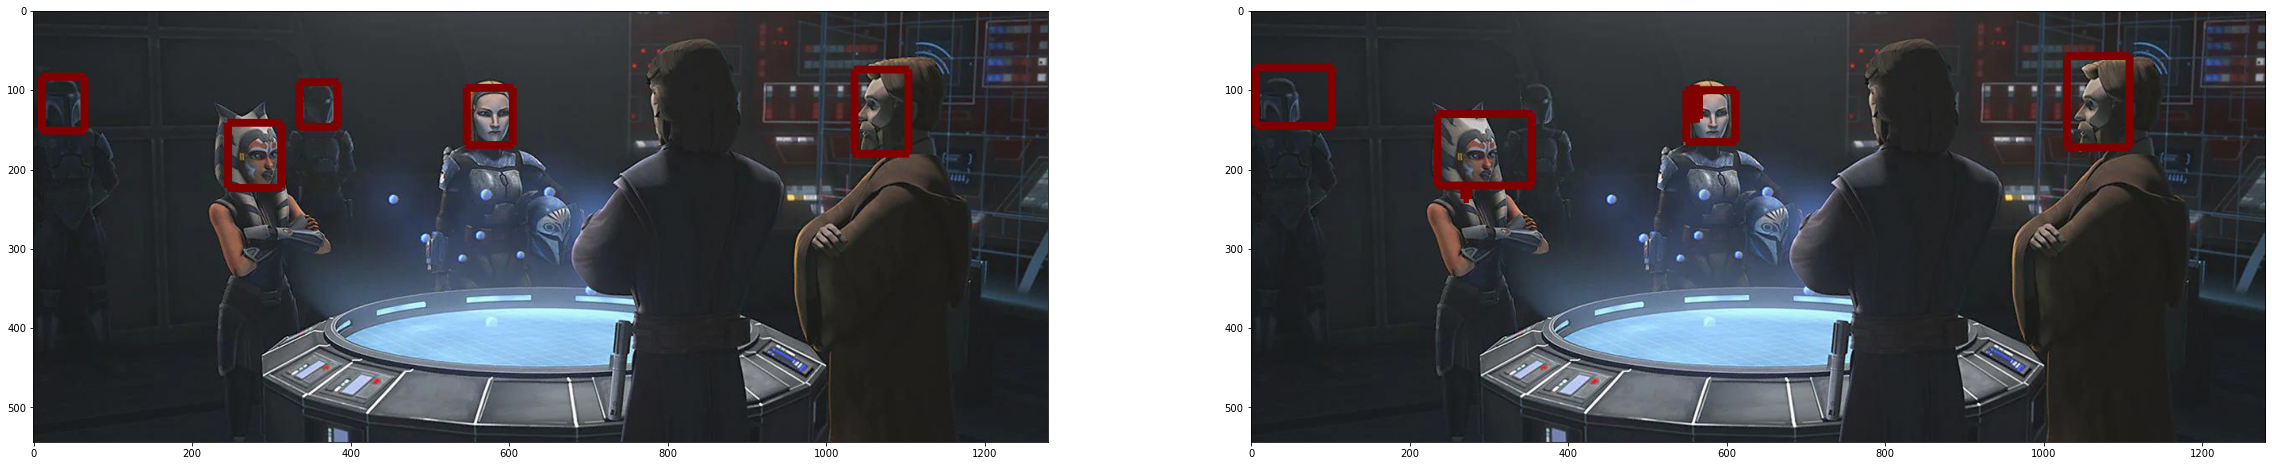

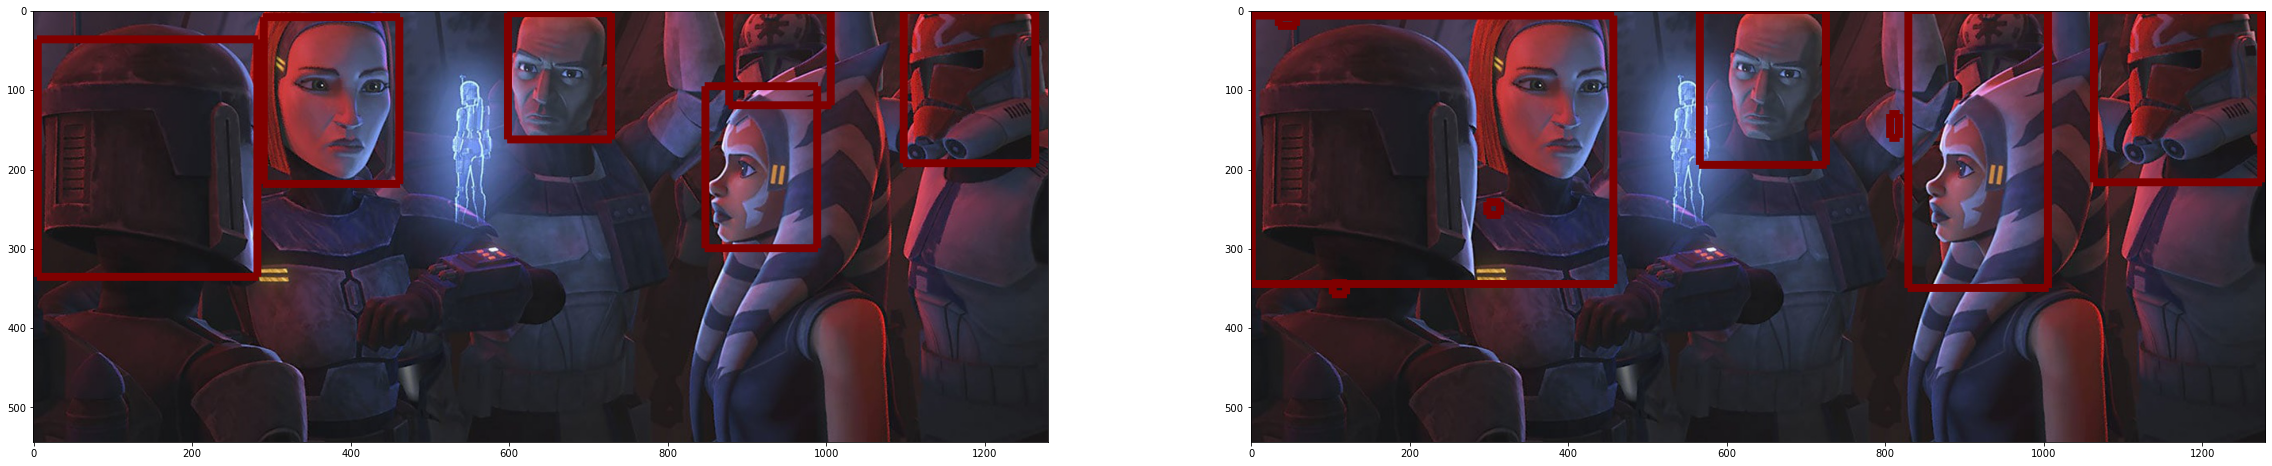

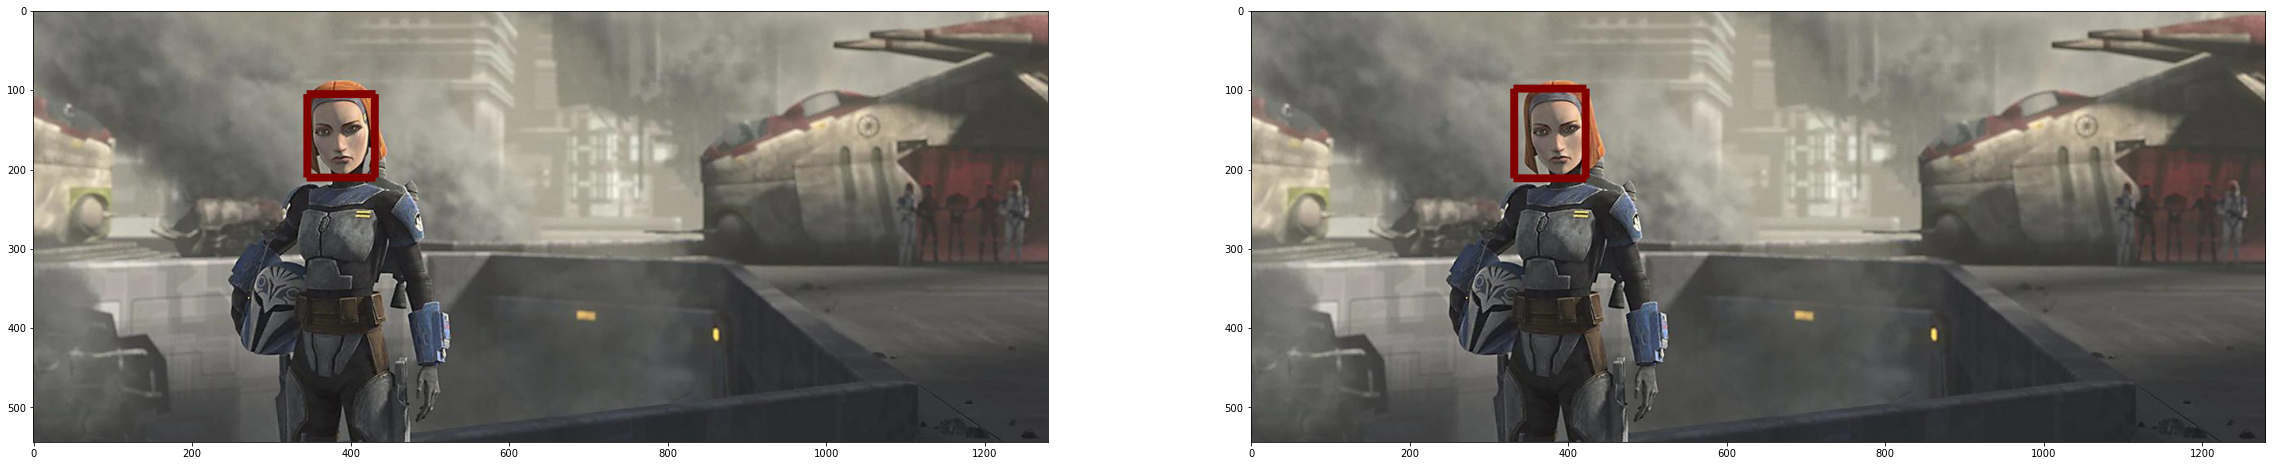

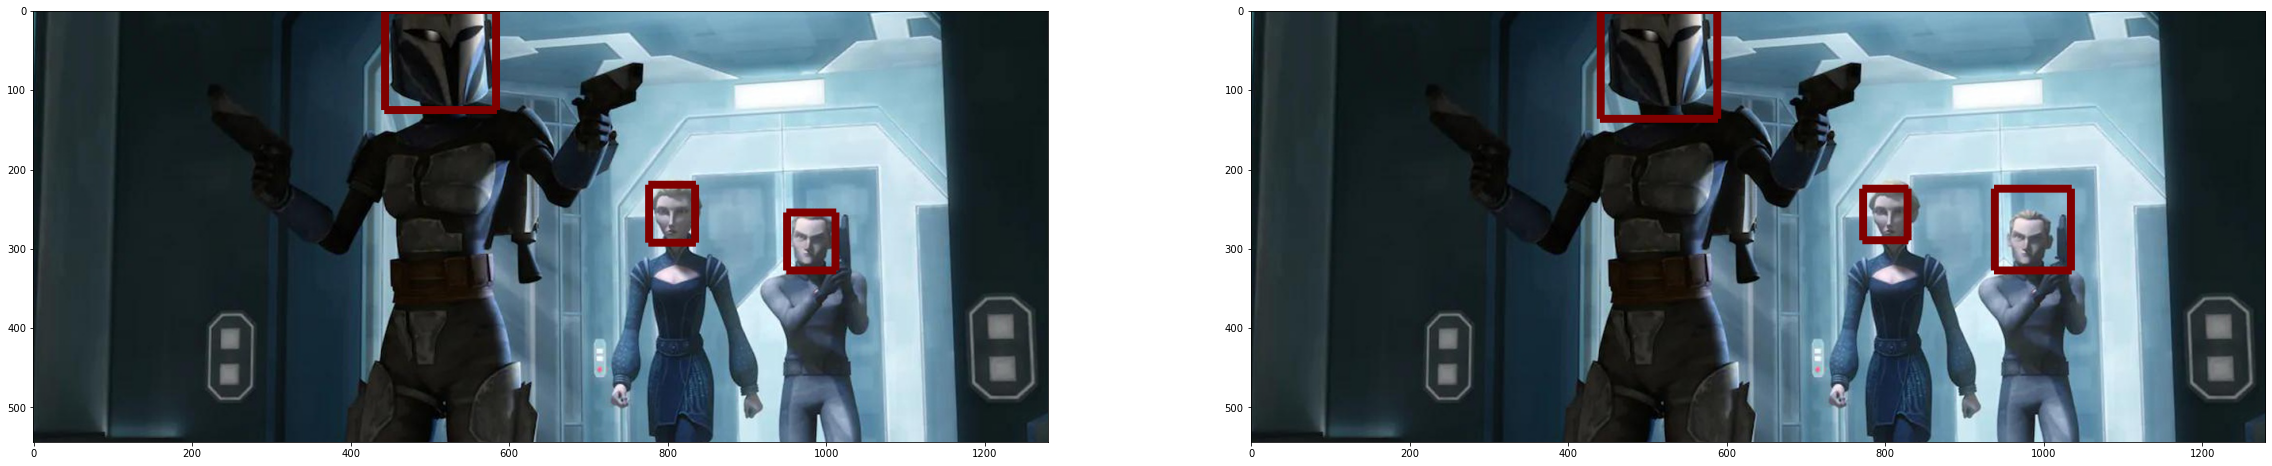

In [17]:
show_labeled(*dataset.get_test(5), vgg16_model, 0.4)

In [18]:
def calculate_iou_levels(arrays, labels):
    X, Y = prepare_dataset(arrays, labels, (224, 224))
    Y_real = labels
    predictions = vgg16_model.predict(X)
    Y_pred = []
    for pred in tqdm(predictions):
        Y_pred.append(probs_to_labels_with_coefs(pred, 0.6, 1280 / 224, 544 / 224))

    for iou in range(1, 11):
        print(iou / 10.0, accuracy(Y_real, Y_pred, iou / 10.0))

    del X
    del Y
    del Y_real
    del Y_pred

In [19]:
calculate_iou_levels(*dataset.get_train(5000))

100%|██████████████████████████████████████████████████████████████████████████████████████████| 1156/1156 [00:03<00:00, 307.86it/s]


0.1 0.9336860670194004
0.2 0.8987654320987655
0.3 0.8684303350970017
0.4 0.8423280423280424
0.5 0.8098765432098766
0.6 0.764021164021164
0.7 0.6892416225749559
0.8 0.5544973544973545
0.9 0.24585537918871253
1.0 0.0


In [20]:
calculate_iou_levels(*dataset.get_test(5000))

100%|████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 340.64it/s]


0.1 0.9315476190476191
0.2 0.8988095238095238
0.3 0.8779761904761905
0.4 0.8244047619047619
0.5 0.7916666666666666
0.6 0.7261904761904762
0.7 0.6458333333333334
0.8 0.5029761904761905
0.9 0.23511904761904762
1.0 0.0


In [21]:
calculate_iou_levels(*dataset.get_validation(5000))

100%|████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 346.86it/s]


0.1 0.9470404984423676
0.2 0.9127725856697819
0.3 0.8785046728971962
0.4 0.8411214953271028
0.5 0.8099688473520249
0.6 0.7881619937694704
0.7 0.719626168224299
0.8 0.5607476635514018
0.9 0.2523364485981308
1.0 0.0


In [22]:
create_video(
    model=vgg16_model,
    source="data/CW/Ahsoka.mp4",
    result="data/CW/Ahsoka_labeled_VGG.mp4",
    dataset_transaformer=lambda arr: prepare_dataset(arr, ((),) * len(arr), (224, 224))[
        0
    ],
    result_transformer=lambda pred: probs_to_labels_with_coefs(
        pred, 0.8, 1280 / 224, 544 / 224
    ),
    start_pos=10 * 60,
    total_count=1000,
    fps=20,
)

<VideoCapture 0000021173F66390>
828601953.0


100%|██████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:04<00:00, 211.31it/s]


(1001, 544, 1280, 3)
